# Development of a single-link PCI filter

This notebook explores single-link channel PCI filtering.



## 0. Necessary installations

Installation of the LISA Simulation suite is required, just like in the workshop:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/constants.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/instrument.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/gw-response.git@latest
    pip install pytdi
    pip install backgrounds

In [1]:
import importlib
#importlib.reload(pytdi)
import numpy as np
import copy
from scipy import signal, constants, interpolate
from matplotlib import pyplot as plt
import h5py
# Instrument
#from lisainstrument import Instrument
#from lisainstrument.containers import ForEachSC
#from lisainstrument.containers import ForEachMOSA
# TDI
#from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi.intervar import ETA_SET
from pytdi import Data
# PCI
#from pylisa import covariance, apci, plotting, sensitivity, eigen
from pcipy import plotting, pci_filter, channel_analysis 
from sklearn.decomposition import PCA
# FTT modules
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
!free

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324      713032    13233404        1276     1964888    14888068
Swap:             0           0           0


In [2]:
# Choose files and options

datadir = "/data/jgbaker/software/pylisa/data/"
orbits = datadir+"keplerian-orbits.h5"
workdir = datadir+"/simulations/"

baseline = True

if baseline:
    noise_file_base = "2025-09-01_18h08_baseline_"
else:
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
gw_file_base = "2025-07-01_19h34_"


skip_hours=4
pci_hours=12

In [3]:
mosas_order = ['12', '23', '31', '13', '21', '32']
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full


In [4]:
# If we use a file
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)


fs = data_noise.fs
skip = int(skip_hours * 3600 * fs)  #We skip the earliest part of the sim which is not representative

y_full = build_data_vector(data_noise, skip=skip)

# Get secondary noises
# sec_file = "/work/SC/lisa/baghiq/pci/simulations/23-05-2022_10h10_noise_sec_4Hz.h5"
# sec_file = datadir+'/simulations/2024-29-07_18h06_noise_sec_4Hz.h5'

secpath = workdir + noise_file_base + 'noise_sec_4Hz.h5'

data_sec = Data.from_instrument(secpath)
    
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

#######

central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']

You are using a measurement file in a development version
You are using a measurement file in a version that might not be fully supported
You are using a measurement file in a development version
You are using a measurement file in a version that might not be fully supported


In [5]:
# TDI2 fractional delay Lagrange interpolating polynomials are of order 31=1+15*2
# Overall TDI delays are up to 8x single link delay = 8.34 s * 4 Hz * 8 = about 267 sample
# Add 15 on each end: 267 + 2*15 = 297   
# TDI2 overall stencil is then about 297 samples
# aPCI overall stencil width is 1 + nhalf*2
nhalf = 45
#ns = int(12 * 3600 * fs) # Use 12 hours data
ns = int(pci_hours * 3600 * fs) # For testing
window = np.ones(ns)

In [6]:
print(y_full[0:ns,:].T)

[[-8.93992083e-12 -9.09568730e-12 -9.00860118e-12 ... -5.12611356e-11
  -5.13874040e-11 -5.13721272e-11]
 [-3.88131490e-11 -3.88997347e-11 -3.92211209e-11 ... -1.15038449e-10
  -1.15130051e-10 -1.15407255e-10]
 [ 4.81292815e-11  4.77925477e-11  4.79810760e-11 ...  1.66436317e-10
   1.66642477e-10  1.66191950e-10]
 [-4.80885270e-11 -4.80896176e-11 -4.81365705e-11 ... -1.66560698e-10
  -1.66578797e-10 -1.66449632e-10]
 [ 9.29409697e-12  9.09490282e-12  9.00116211e-12 ...  5.14666240e-11
   5.15380031e-11  5.13020876e-11]
 [ 3.94645385e-11  3.91650614e-11  3.92760726e-11 ...  1.15087530e-10
   1.15400390e-10  1.15138048e-10]]


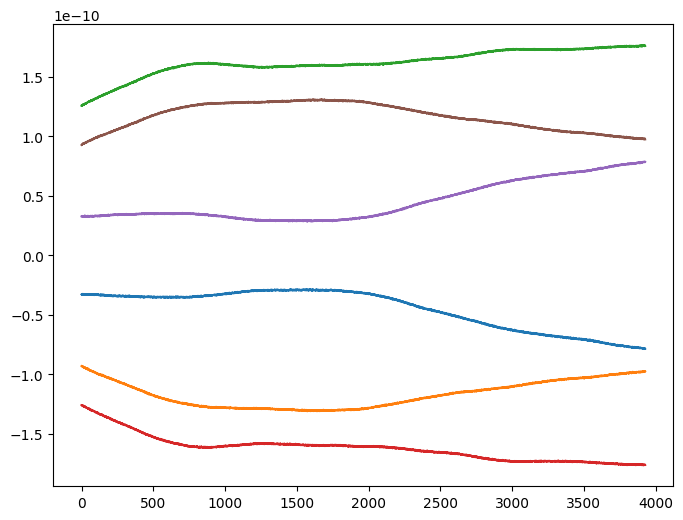

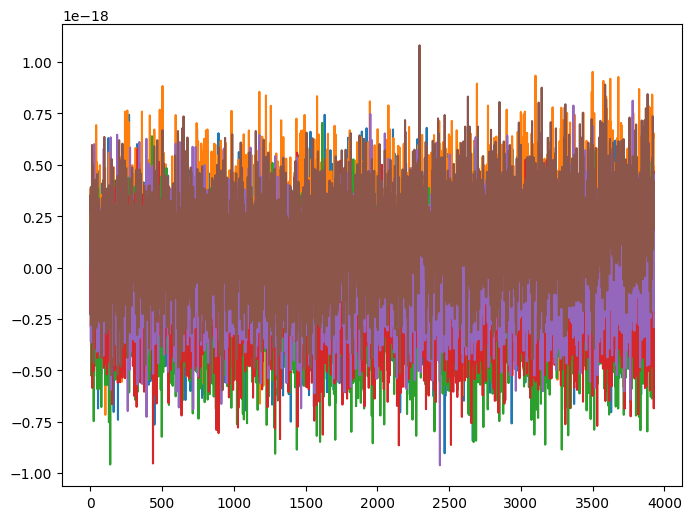

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     2329704    10439072        1276     3142548    13270024
Swap:             0           0           0


In [7]:
# Check time series
maxshow=4000
ev=ns//maxshow+1
_, axes = plt.subplots(1, 1, figsize=(8, 6))
for ich in range(len(y_full.T)):
    axes.plot(y_full[skip:skip+ns:ev, ich])
plt.show()

_, axes = plt.subplots(1, 1, figsize=(8, 6))
for ich in range(len(y_sec.T)):
    axes.plot(y_sec[skip:skip+ns:ev, ich])
plt.show()
!free

In [8]:
import importlib
Tscale=10
importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, sort_by_rms=False,Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


shape in build datamatrix (172800, 546)
(172800, 546)
variance check rms: 9.709916594302268e-12
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 2.072363809228467e-12
component diagonality test on 10 components: 5.399069129757999e-16
shape in build datamatrix (172800, 1092)
(172800, 1092)
variance check rms: 8.735962054854164e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.         1.         1.
 1.00000001 1.         1.         1.        ]
channel covariance diagonality test on 10 components: 6.881248393529953e-09
component diagonality test on 10 components: 3.790809148171527e-16
shape in build datamatrix (172800, 1638)
(172800, 1638)
variance check rms: 7.029281035262596e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.         1.         1.         0.99999999 0.99999999 1.00000002
 1.00000003 1.    

In [9]:
import importlib
importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, sort_by_rms=True,Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


shape in build datamatrix (172800, 546)
(172800, 546)
variance check rms: 9.709916594302268e-12
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 2.072363809228467e-12
component diagonality test on 10 components: 5.399069129757999e-16
shape in build datamatrix (172800, 1092)
(172800, 1092)
variance check rms: 8.735962054854164e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 3.207596355673916e-09
component diagonality test on 10 components: 4.1189434006301133e-16
shape in build datamatrix (172800, 1638)
(172800, 1638)
variance check rms: 7.029281035262595e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.         1.         1.         1.         1.00000002 1.00000003
 0.99999999 1.         0.99999999 1.00000001]
channel covariance diagonality test on 10 co

In [10]:
#importlib.reload(pci_filter)
#pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, zero_mean=True, Tscale=Tscale)            
#            for q in range(3)]


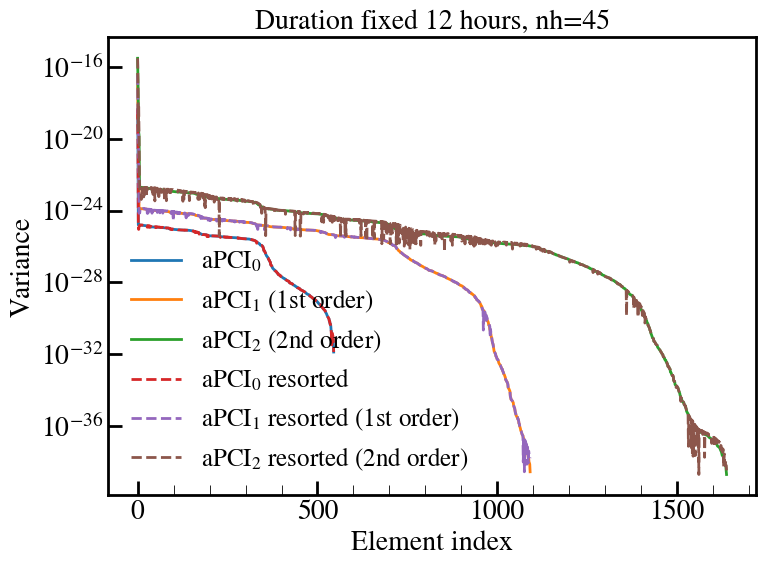

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1622600    14059576        1276      229148    14004452
Swap:             0           0           0


In [11]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

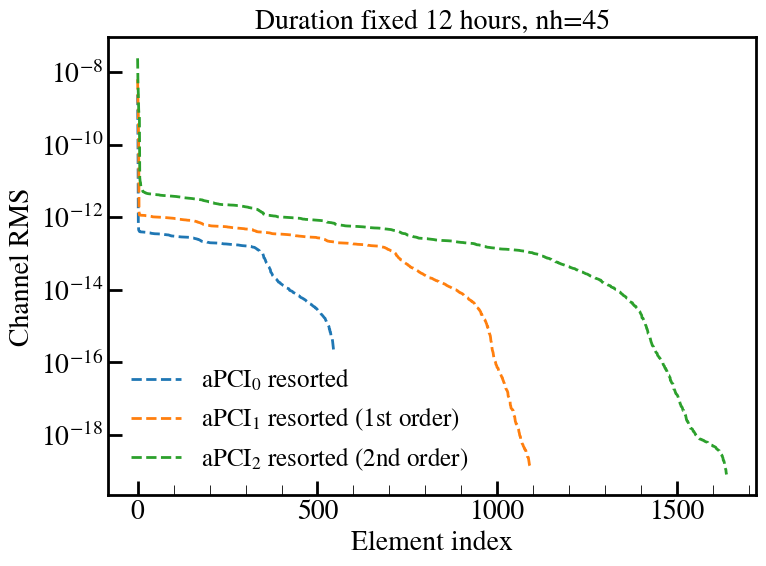

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1623464    14058660        1276      229200    14003596
Swap:             0           0           0


In [12]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

if False:
    ax1.plot(pca_list[0].explained_rms, 
                #linestyle='dashed',
                label=r'aPCI$_0$',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list[1].explained_rms, 
                #linestyle='dashed',
                label=r'aPCI$_1$ (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list[2].explained_rms,
                #linestyle='dashed',
                label=r'aPCI$_2$ (2nd order)',
                linewidth=2,
                rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_rms, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_rms, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_rms,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_rms, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_rms, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_rms,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Channel RMS", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

shape in build datamatrix (172800, 1092)
shape in build datamatrix (172800, 1638)
i= 0
mean: 1.5935890800261815e-20
variance:  1.7839953981874872e-38
mean: -6.457312843465703e-20
variance:  1.572855534126876e-38
mean: 1.684285947815046e-21
variance:  2.3242280442196004e-38
mean: 6.4540916446568e-20
variance:  2.776084711126313e-38
i= 1
mean: -5.666444374361603e-20
variance:  3.307680562305323e-39
mean: 3.85428822033586e-21
variance:  8.019750507492446e-39
mean: -2.9484329299127416e-20
variance:  1.1404608761334288e-38
mean: -6.652206558241984e-20
variance:  9.000136184068904e-39


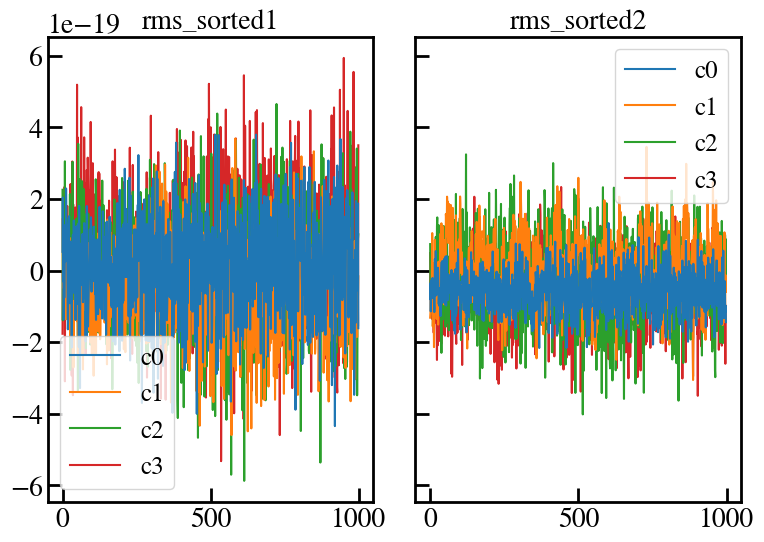

In [13]:
importlib.reload(channel_analysis)
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.stationarity_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=1,split_orders=True,title=['zero_mean','rms_sorted'])
#channel_analysis.stationarity_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])
filters=[pca_list_rs[order-1],pca_list_rs[order]]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=4,zero_mean=False,detrend=False)) for xf in filters]
channel_analysis.stationarity_plots(sets,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])

shape in build datamatrix (172800, 1092)
shape in build datamatrix (172800, 1638)
i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


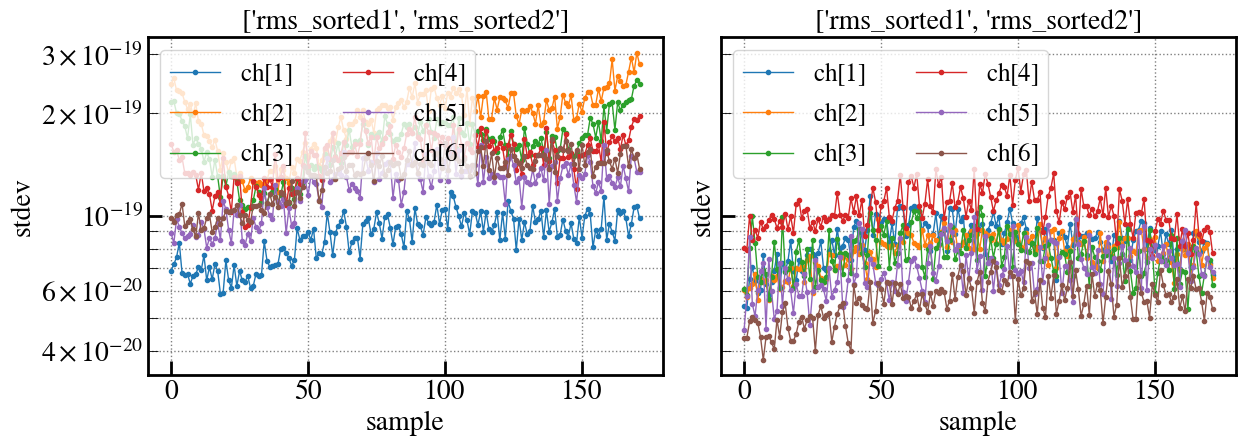

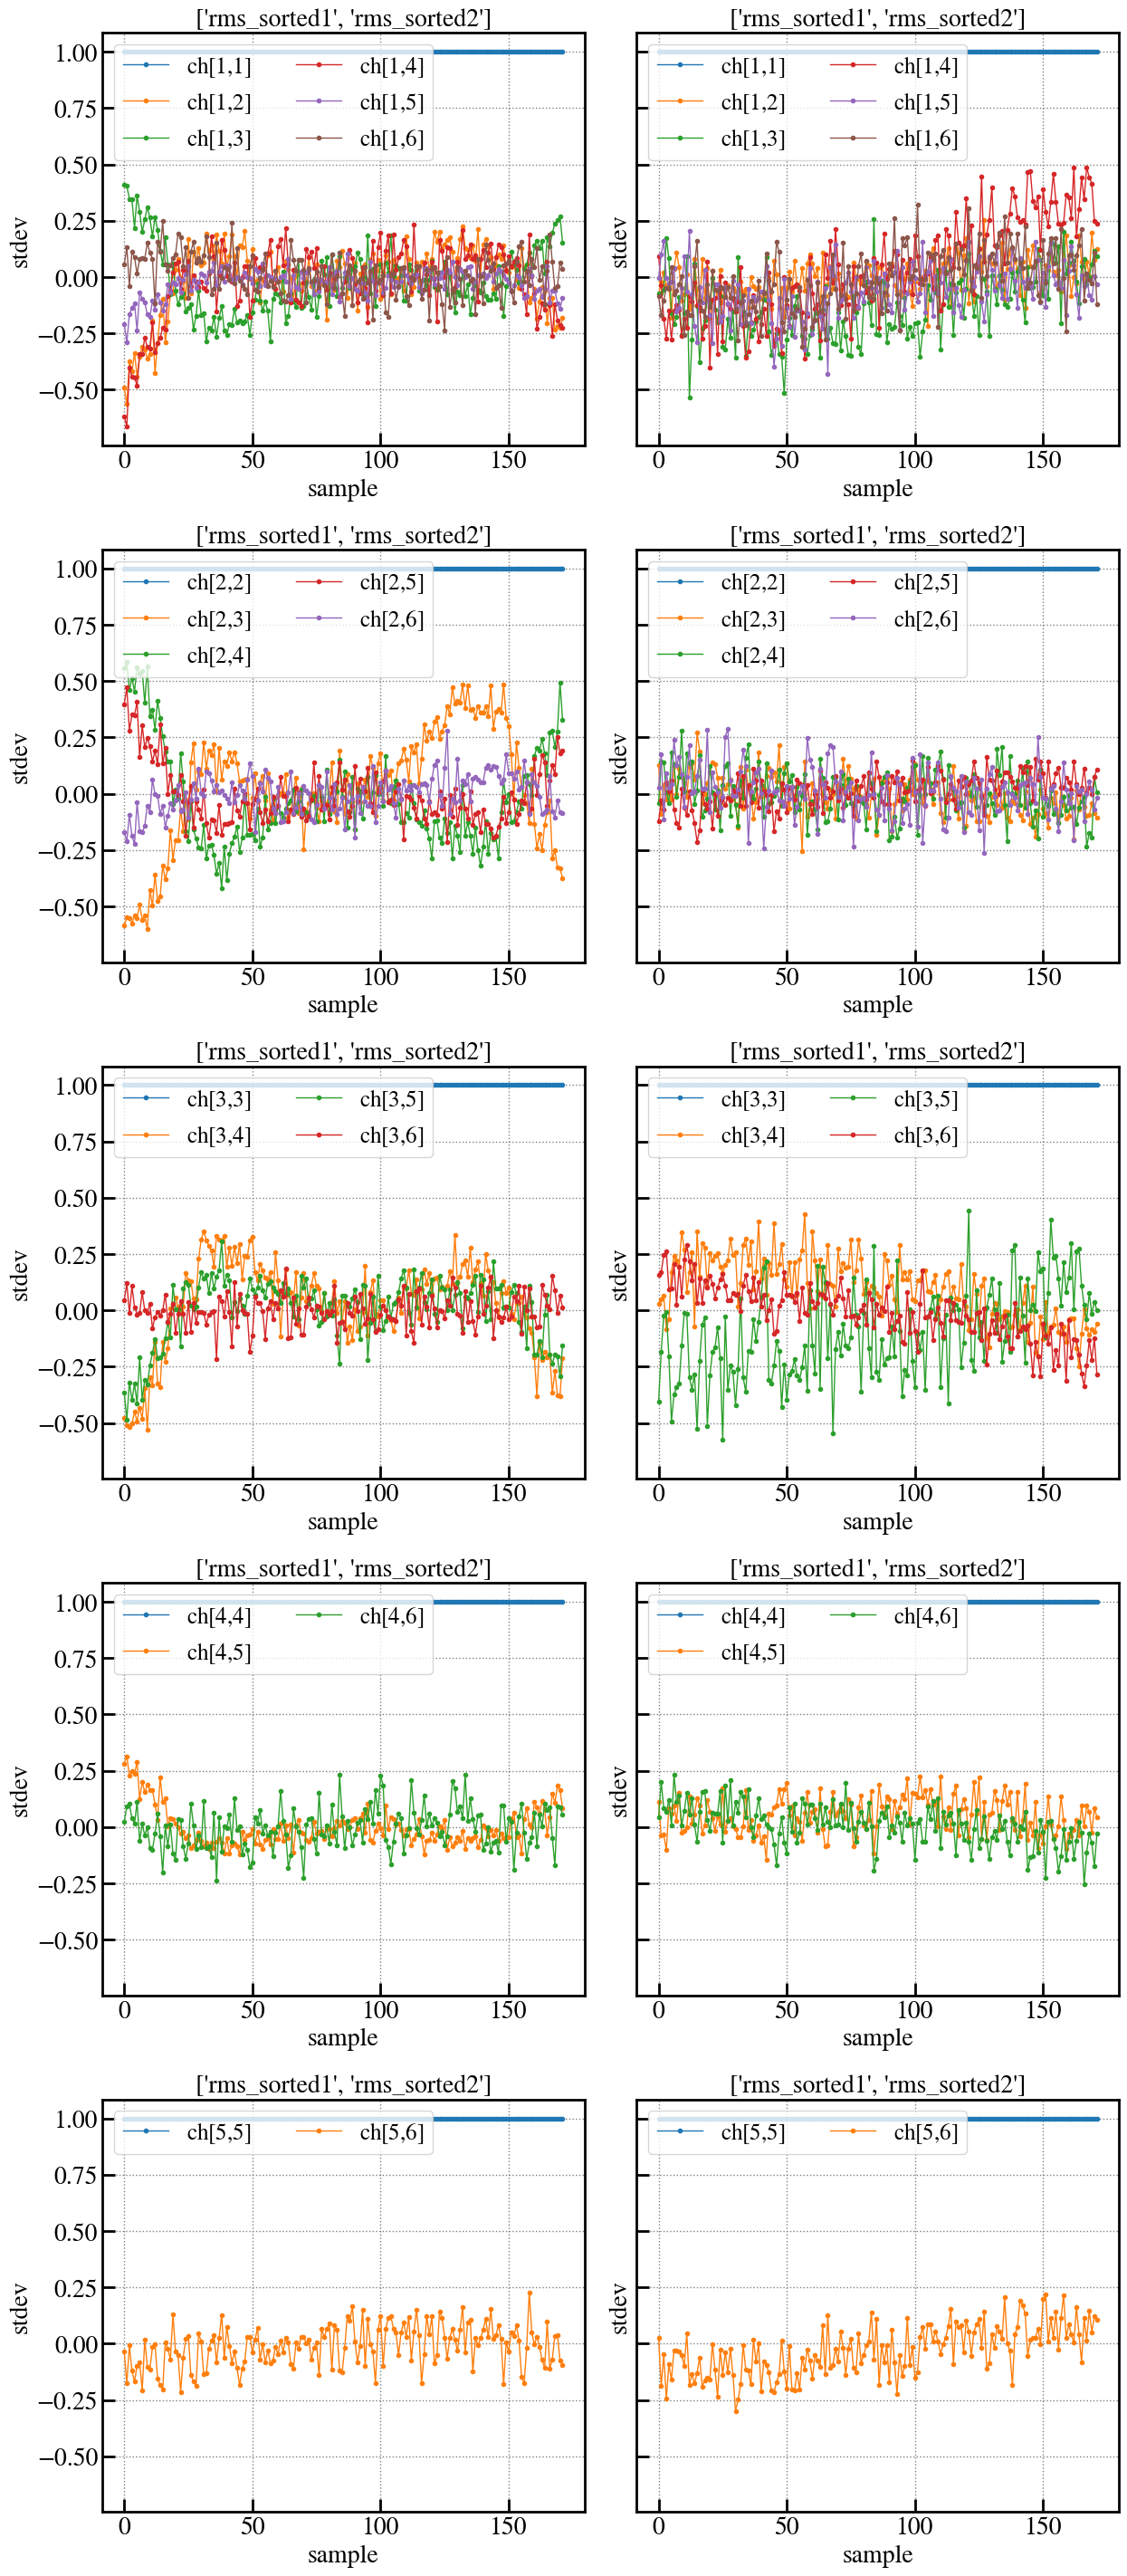

In [14]:
importlib.reload(channel_analysis)
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.temporal_variance_corr_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=3,title=['zero_mean','rms_sorted'])
#channel_analysis.pci_temporal_variance_corr_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])
filters=[pca_list_rs[order-1],pca_list_rs[order]]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=6,zero_mean=False,detrend=False)) for xf in filters]
channel_analysis.temporal_variance_corr_plots(sets,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])

### Frequency domain plots

In [15]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat


In [16]:
nperseg = 2**16 #didn't work with some, too short data segment (6hr)?
nperseg = 2**14
kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}
freqs, y_welch_mat = compute_welch_matrix(y_full, **kwargs)
freqs, y_sec_welch_mat = compute_welch_matrix(y_sec, **kwargs)

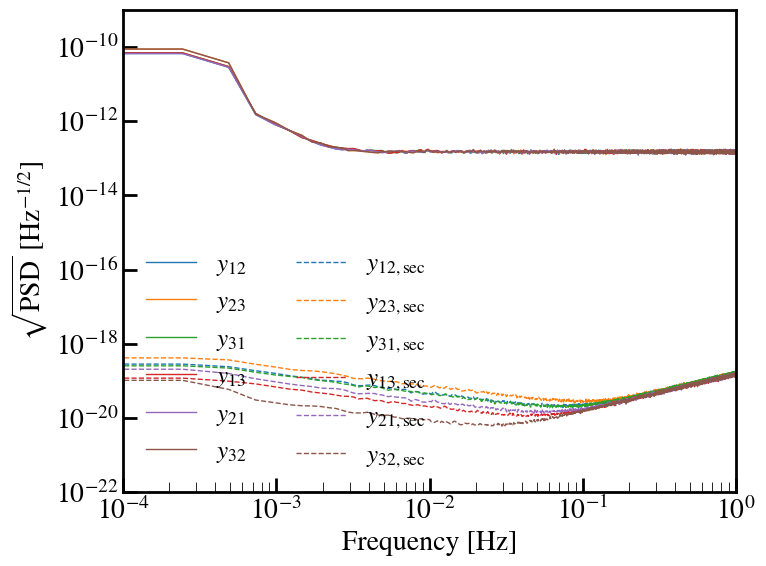

In [17]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_welch_mat[:, i, i].real), 
                linewidth=1, 
                label=r'$y_{\mathrm{'+mosas_order[i]+'}}$',
                rasterized=True)
plt.gca().set_prop_cycle(None)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1,ls='--', 
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-22, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

### Single link reconstruction

We can recover an approximation of the single link channels by transforming back to the original input channels. This is realted to application of the "ZCA" zero-phase component analysis.

shape in build datamatrix (172800, 1092)
shape in build datamatrix (172800, 1638)
Computing single link
single link shape (6, 172800)
single link shape (6, 172800)
Computed single link
i= 0
mean: -2.093467775348125e-23
variance:  2.7771286937722766e-44
mean: -1.2410637845746556e-23
variance:  8.478081951664984e-46
mean: 1.6474854069319214e-22
variance:  3.369047792897741e-43
mean: 2.093448852768052e-23
variance:  2.77712596677854e-44
mean: 1.2410269877676831e-23
variance:  8.478602687885719e-46
mean: -1.6474849769115776e-22
variance:  3.3690454824350533e-43
i= 1
mean: -4.211636435566235e-24
variance:  3.2629895843266613e-44
mean: 6.116466908817695e-23
variance:  8.66792096483473e-45
mean: 2.8029084951274124e-23
variance:  7.879751486628831e-44
mean: 4.210595242462255e-24
variance:  3.262984784351211e-44
mean: -6.116432830600663e-23
variance:  8.667785644133324e-45
mean: -2.802894342690029e-23
variance:  7.879758788991135e-44
i= 2
mean: 9.350585376337146e-20
variance:  4.842878871305011

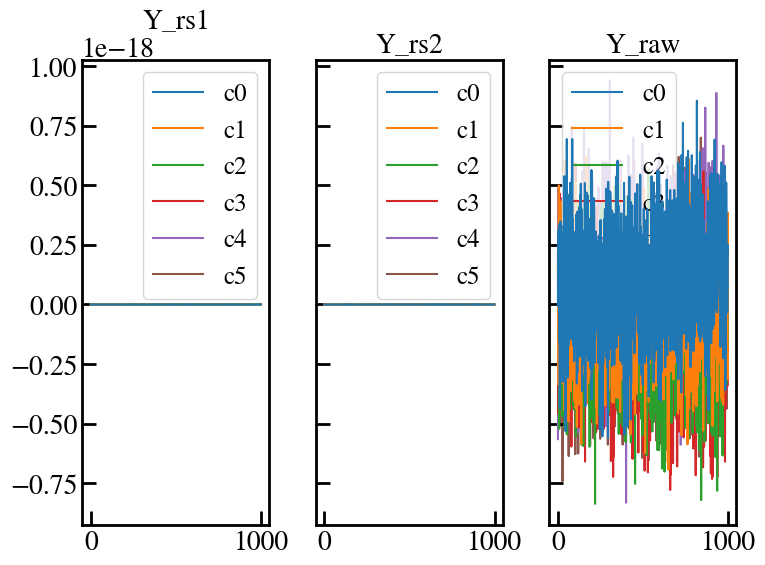

In [18]:
importlib.reload(channel_analysis)
order=2
nchannels=10
ev=100
filters=[pca_list_rs[order-1],pca_list_rs[order]]
[xf.set_stencil(nchannels) for xf in filters]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=nchannels,zero_mean=False,detrend=False)) for xf in filters]
print("Computing single link")
Ysets=[xf.compute_single_links_from_channels(iset) for xf,iset in zip(filters,sets)]
titles=['Y_rs'+str(order-1),'Y_rs'+str(order)]
if True:
    Ysets+=[y_sec[nhalf:ns+nhalf, :].T]
    titles+=['Y_raw']
print("Computed single link")
channel_analysis.stationarity_plots(Ysets,title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


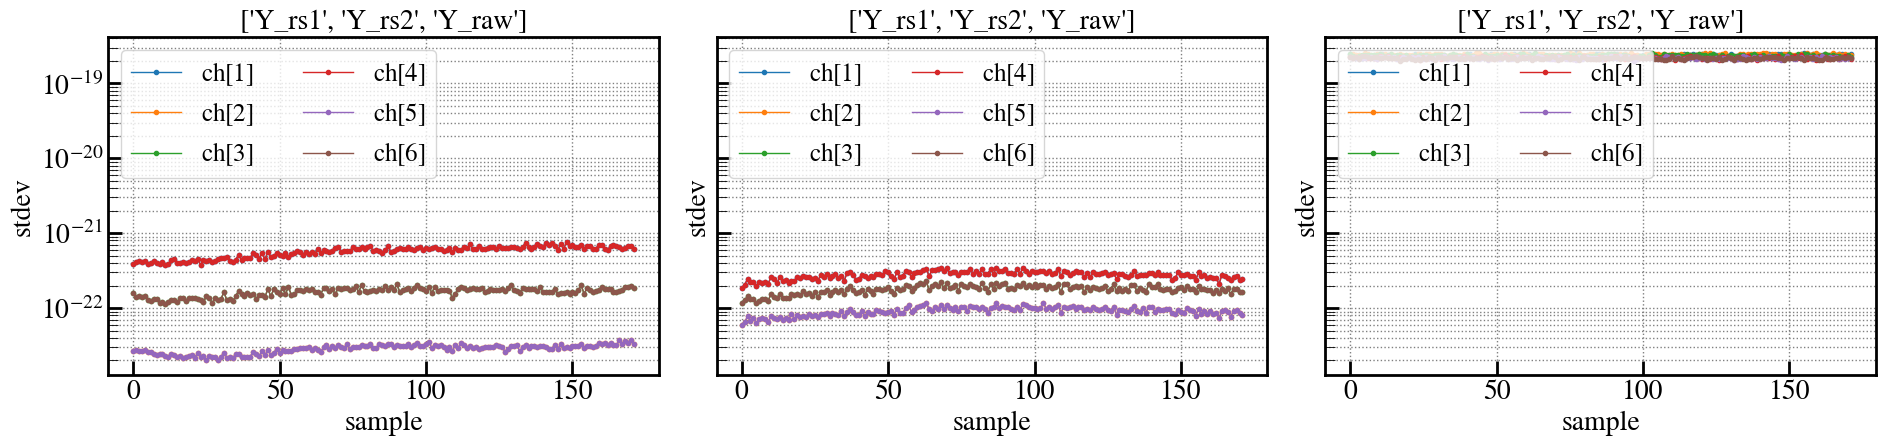

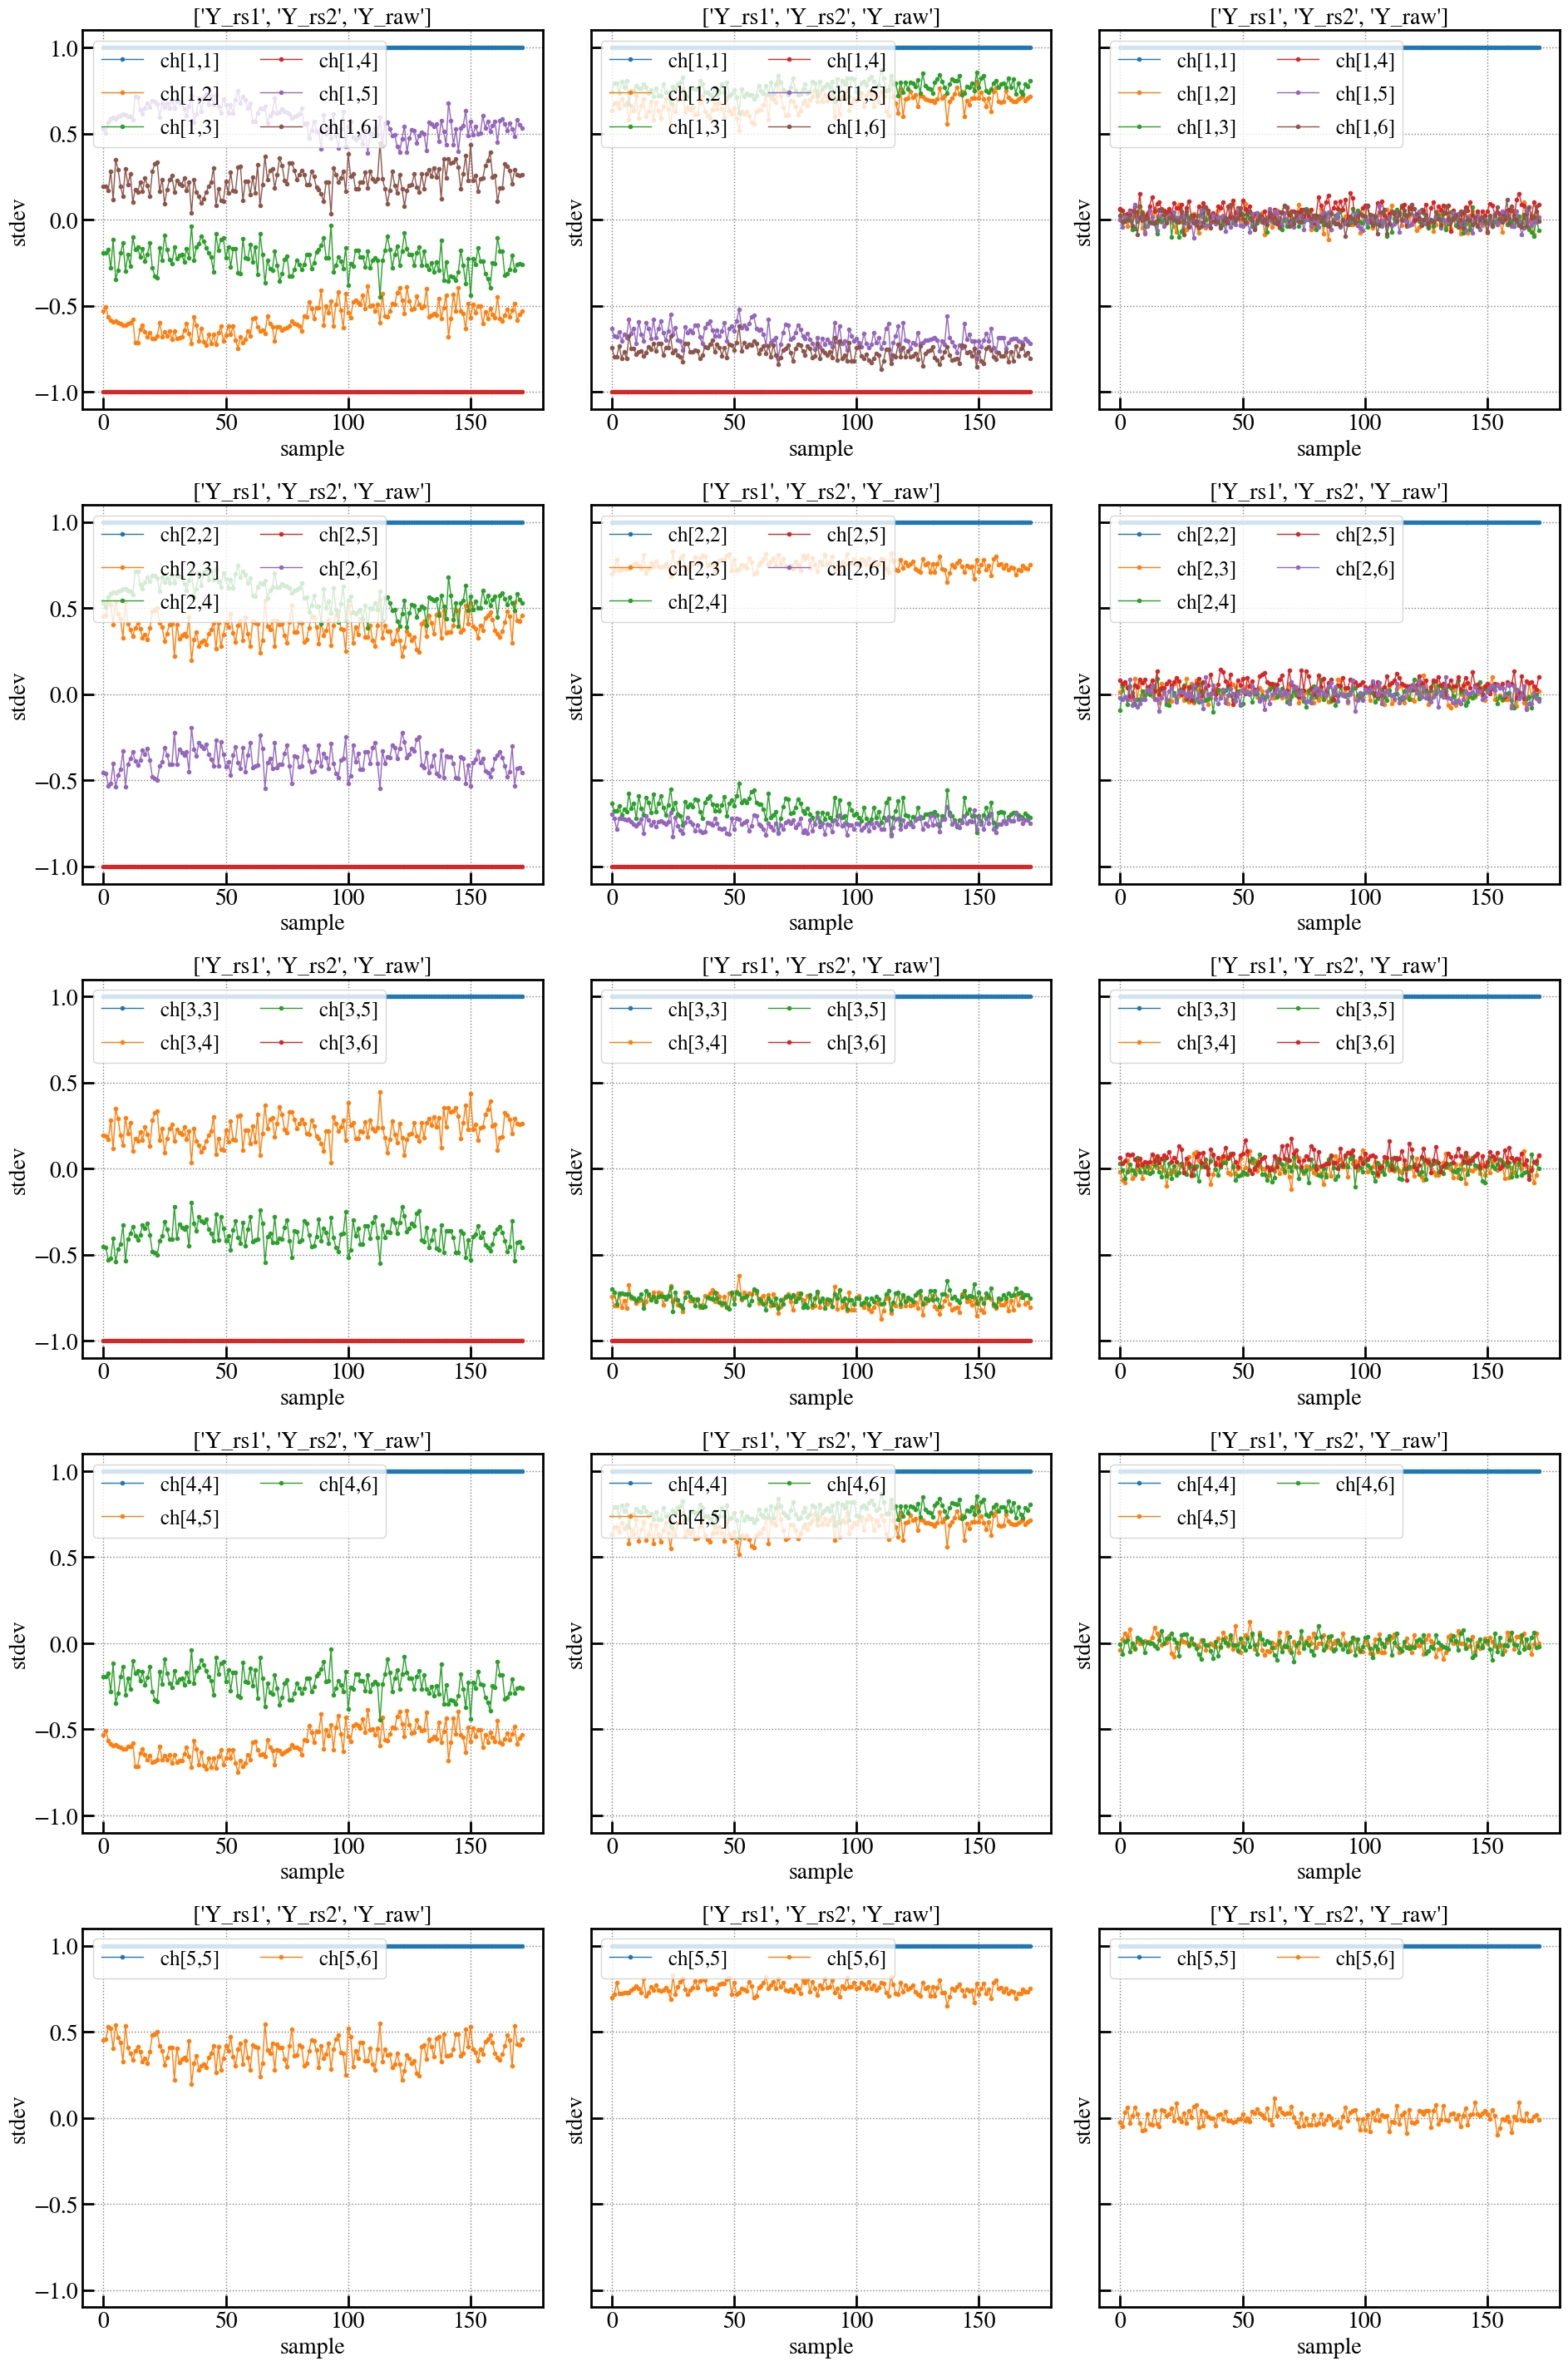

In [19]:
importlib.reload(channel_analysis)
channel_analysis.temporal_variance_corr_plots(Ysets[:],nchan=6,title=titles)

In [20]:
freqs1, y_pci1_welch_mat = compute_welch_matrix(Ysets[0].T, **kwargs)
freqs2, y_pci2_welch_mat = compute_welch_matrix(Ysets[1].T, **kwargs)

In [21]:
print([x.shape for x in [freqs,freqs1,freqs2]])

[(8193,), (8193,), (8193,)]


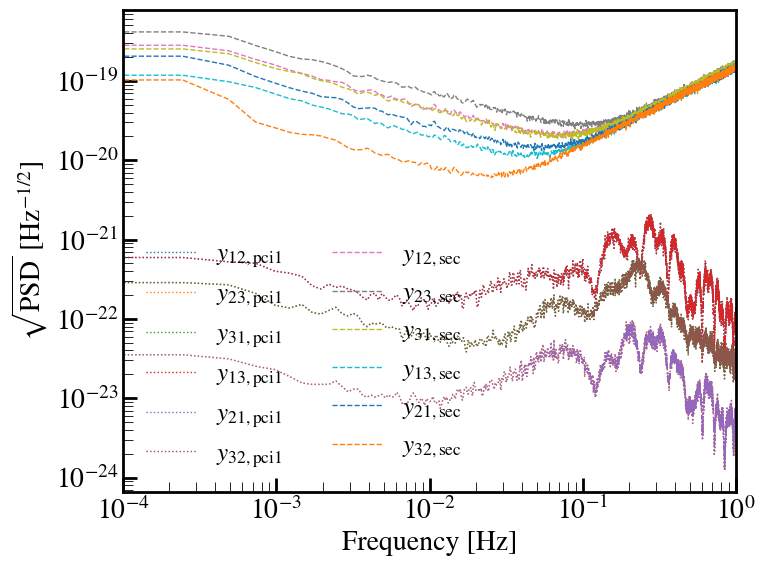

In [22]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_pci1_welch_mat[:, i, i].real), 
                linewidth=1, ls=':',
                label=r'$y_{\mathrm{'+mosas_order[i]+',pci1}}$',
               rasterized=True)
#for i in range(6):
#    axes.loglog(freqs, np.sqrt(y_pci2_welch_mat[:, i, i].real), 
#                linewidth=1, 
#                label=r'$y_{\mathrm{'+mosas_order[i]+',pci2}}$',
#               rasterized=True)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1, ls='--',
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
#axes.set_ylim([1e-25, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

#### Alternative Y-reconstruction test

In [23]:
    def filter_single_link_data(self, ydata,n_channels=None):
        '''
        Compute recovered single-link channel vectors from a set of single-link data. This should yield 
        identical results to appropriately called compute_single_link_from_channels but we first implement
        separately for testing, since the stencil_compts stuff is new. This one is more low-level and 
        doesn't assum the stencil is selected.
        
        Parameters
        ----------
        ydata : ndarray 
            The raw single-link data-set to be transformed.

        Returns
        -------
        reconstructed_ydata : ndarray
            Reconstructed single link data channels
        '''
        if n_channels is None: n_channels=self.maxcompts
        y_transformer=self.components[-n_channels:,:6].T

        chans_data = self.apply_for_channels(ydata, n_channels)
        Z=np.dot(y_transformer,chans_data)
        print('single link data shape', Z.shape)
        return Z

In [24]:
importlib.reload(channel_analysis)
Zsets=[np.array(xf.filter_single_link_data(y_full[:ns+2*nhalf, :].T, n_channels=nchannels)) for xf in filters]
print("Comparing single link")
diff=[Zsets[i]-Ysets[i] for i in range(order)]
print(diff)

shape in build datamatrix (172800, 1092)
single link data shape (6, 172800)
shape in build datamatrix (172800, 1638)
single link data shape (6, 172800)
Comparing single link
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


## Sensitivity calculations
These follow what is initial-dev-from-pylisa


### Computation of empirical response with welch periodograms
Based and empirical sensitivity calculation simulated signal over simulated noise as developed in initial-dev-from-pylisa

In [25]:
# Some options and prep for the welch_matrix calc
nperseg = 1e4
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

#and for the orthogonalization...
#multiple_dot = lambda a,b: np.einsum("ijk, ikl -> ijl", a, b)
def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)


In [26]:

def estimate_sensitivity(pci, data_n, data_gw, n_channels=6, joint=True, single_link=False, welch_kwargs=welch_kwargs):
    
    # PCI transformation vector, size n_channel x p
    #v_pci = pci.v_pci(n_channels)
    # Projection of the data segment t
    #print('compute noise channels')
    #print('for',n_channels,'channels')
    #print('components shape',pci.components.shape)
    if single_link:
        e_pci_n = pci.filter_single_link_data(data_n,n_channels).T
        e_pci_gw = pci.filter_single_link_data(data_gw,n_channels).T
    else:
        e_pci_n = pci.apply_for_channels(data_n,n_channels).T
        e_pci_gw = pci.apply_for_channels(data_gw,n_channels).T
    #print(e_pci_n.shape,e_pci_n.shape)
    #print('compute welch')
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **welch_kwargs)
    print(freqs, e_pci_n_mat)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **welch_kwargs)
    print(freqs, e_pci_gw_mat)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal    
    e_pci_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    print("Computation completed.")
    if joint:
        pci_sens = 1 / np.sum(1/np.array(pci_sens), axis=1)
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, fs, nhalf, order=1, n_channels=6, pca_y_noise=None, joint=False, pci_kwargs={}, welch_kwargs={}):
    '''
    Apply PCI and compute sensitivity all wrapped up together. If pda_y_noise is provided it is used
    only for computing the PCI and y_noise is used only for the sensitivity application
    '''
    
    if pca_y_noise is None: pca_y_noise=y_noise
        
    print('nhalf:',nhalf, 'sens data_size:',len(y_noise),'pca data_size:',len(pca_y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)

    print('compute PCI')
    pci=pci_filter.PCIFilter(y_noise, fs, maxcompts=10, nhalf=nhalf,order=order,**pci_kwargs)
    
    result=estimate_sensitivity(pci, y_noise, y_gw, n_channels=n_channels, joint=joint, welch_kwargs=welch_kwargs)
    del(pci)
    
    return result

#### We need to read matching GW simulations results for the empirical sensitivity calculation

In [27]:
# gw_path = '../data/realizations_gw/gw_pointsource_1.h5'
#gw_path = "/work/SC/lisa/baghiq/pci/simulations//2022-23-05_13h59_gw_measurements_4Hz.h5"
#gw_path = datadir+"simulations/2024-04-10_18h35_gw_measurements_4Hz.h5"
gw_path = workdir+gw_file_base+"gw_measurements_4Hz.h5"

data_gw = Data.from_gws(gw_path,orbits)

#gw_dataset='tps/y'
#hdf5 = h5py.File(gw_path, 'r')
#dset=hdf5[gw_dataset]

#measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(mosas_order)}
#hdf5.close()

y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T[skip:, :]


You are using a GW file in a development version
You are using a GW file in a version that might not be fully supported


#### For comparison, we also need the TDI data

In [28]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath2 = workdir +  noise_file_base + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
#tdi1 = h5py.File(tdipath1, 'r')
tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

tdi2_gw_file = workdir+gw_file_base+"gw_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()]
y2_gw = hdf5['y'][()]
z2_gw = hdf5['z'][()]
hdf5.close()

# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, 

multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)

#### PCI channel sensitivities

In [29]:
print(ns)
print(y_full[0:ns,:].T)
print(y_gw[0:ns,:].T)
display(welch_kwargs)

172800
[[-8.93992083e-12 -9.09568730e-12 -9.00860118e-12 ... -5.12611356e-11
  -5.13874040e-11 -5.13721272e-11]
 [-3.88131490e-11 -3.88997347e-11 -3.92211209e-11 ... -1.15038449e-10
  -1.15130051e-10 -1.15407255e-10]
 [ 4.81292815e-11  4.77925477e-11  4.79810760e-11 ...  1.66436317e-10
   1.66642477e-10  1.66191950e-10]
 [-4.80885270e-11 -4.80896176e-11 -4.81365705e-11 ... -1.66560698e-10
  -1.66578797e-10 -1.66449632e-10]
 [ 9.29409697e-12  9.09490282e-12  9.00116211e-12 ...  5.14666240e-11
   5.15380031e-11  5.13020876e-11]
 [ 3.94645385e-11  3.91650614e-11  3.92760726e-11 ...  1.15087530e-10
   1.15400390e-10  1.15138048e-10]]
[[-0.76902917 -0.20896402  1.56797135 ...  3.56682723  3.16536401
  -0.92469513]
 [-0.01047133  1.41756118 -3.15478226 ...  0.92193175 -0.99553981
   0.93588046]
 [ 0.06171468 -0.32405731 -0.9063305  ...  0.2077347  -0.12155155
  -0.21458021]
 [ 0.2077513   0.2078394  -1.71184114 ... -4.77085876 -0.58806
   0.0934467 ]
 [-0.02929765  0.31701532  0.75203783 ...

{'fs': 4.0,
 'window': 'blackman',
 'nperseg': 10000.0,
 'detrend': 'constant',
 'return_onesided': True,
 'scaling': 'density'}

In [30]:
#Test as it appears in the initial-dev notebook
nh=45
pci_sens_list = [
#    ["PCI-0 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-1 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-2 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-0 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
#    ["PCI-1 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
    ["PCI-2 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, fs, nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=welch_kwargs)] 
]

nhalf: 45 sens data_size: 6 pca data_size: 6
compute PCI
shape in build datamatrix (172710, 1638)
(172710, 1638)
variance check rms: 5.557383441145834e-08
shapes of chans, cov, components: (10, 172710) (10, 10) (10, 1638)
[1.         1.         1.00000001 1.         1.         1.
 1.00000001 1.         0.99999997 1.        ]
channel covariance diagonality test on 10 components: 5.062976946415185e-09
component diagonality test on 10 components: 3.805791403647118e-16
shape in build datamatrix (172710, 1638)
shape in build datamatrix (172710, 1638)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 2.09267488e-39+0.00000000e+00j -6.96012419e-40+0.00000000e+00j
   -1.64082494e-40+0.00000000e+00j -1.37207864e-39+0.00000000e+00j
   -1.72283295e-40+0.00000000e+00j  5.34380057e-40+0.00000000e+00j]
  [-6.96012419e-40-0.00000000e+00j  5.28415439e-40+0.00000000e+00j
    5.57443002e-40+0.00000000e+00j  9.79099645e-40+0.00000000e+00j
   -8.60242456e-41+0.00000000e+00j -3.24

Computation completed.


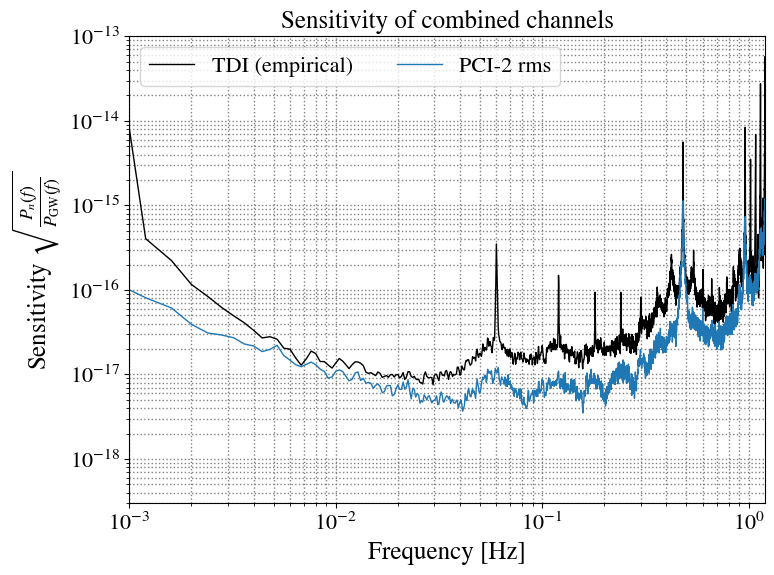

In [31]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [32]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" rms", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]




shape in build datamatrix (172710, 546)
shape in build datamatrix (172710, 546)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 3.28077730e-32+0.00000000e+00j  4.06052612e-33+0.00000000e+00j
    3.39617404e-33+0.00000000e+00j -2.53330483e-34+0.00000000e+00j
    2.83611008e-33+0.00000000e+00j  1.66002637e-33+0.00000000e+00j]
  [ 4.06052612e-33-0.00000000e+00j  1.87742869e-33+0.00000000e+00j
    2.33247701e-33+0.00000000e+00j  8.48987200e-35+0.00000000e+00j
   -1.80142139e-34+0.00000000e+00j  2.54968391e-33+0.00000000e+00j]
  [ 3.39617404e-33-0.00000000e+00j  2.33247701e-33-0.00000000e+00j
    5.62317656e-33+0.00000000e+00j  5.44178841e-34+0.00000000e+00j
   -1.37123016e-33+0.00000000e+00j  6.17254962e-33+0.00000000e+00j]
  [-2.53330483e-34-0.00000000e+00j  8.48987200e-35-0.00000000e+00j
    5.44178841e-34-0.00000000e+00j  5.18685688e-34+0.00000000e+00j
   -3.54017588e-34+0.00000000e+00j  8.67141737e-34+0.00000000e+00j]
  [ 2.83611008e-33-0.00000000e+00j -1.80

Computation completed.
shape in build datamatrix (172710, 1092)
shape in build datamatrix (172710, 1092)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.47288238e-37+0.00000000e+00j  2.74906513e-38+0.00000000e+00j
   -3.98448486e-39+0.00000000e+00j  1.98808834e-38+0.00000000e+00j
    2.50799956e-38+0.00000000e+00j  4.40584454e-39+0.00000000e+00j]
  [ 2.74906513e-38-0.00000000e+00j  1.35858773e-38+0.00000000e+00j
   -4.79679246e-39+0.00000000e+00j  3.33741374e-39+0.00000000e+00j
    2.01615653e-38+0.00000000e+00j -3.36738878e-40+0.00000000e+00j]
  [-3.98448486e-39-0.00000000e+00j -4.79679246e-39-0.00000000e+00j
    2.30553254e-39+0.00000000e+00j -5.40164212e-40+0.00000000e+00j
   -7.92007149e-39+0.00000000e+00j  3.45948214e-40+0.00000000e+00j]
  [ 1.98808834e-38-0.00000000e+00j  3.33741374e-39-0.00000000e+00j
   -5.40164212e-40-0.00000000e+00j  3.08951704e-39+0.00000000e+00j
    2.11389460e-39+0.00000000e+00j  6.70767377e-40+0.00000000e+00j]
  [ 2.50799956e

Computation completed.
shape in build datamatrix (172710, 1638)
shape in build datamatrix (172710, 1638)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 6.19824155e-38+0.00000000e+00j  2.07563606e-39+0.00000000e+00j
    1.85350064e-37+0.00000000e+00j -6.32399164e-38+0.00000000e+00j
    1.04072054e-37+0.00000000e+00j  7.86734079e-39+0.00000000e+00j]
  [ 2.07563606e-39-0.00000000e+00j  1.21417568e-39+0.00000000e+00j
    1.11399391e-38+0.00000000e+00j -2.24744472e-39+0.00000000e+00j
   -1.48281787e-38+0.00000000e+00j -1.61622191e-40+0.00000000e+00j]
  [ 1.85350064e-37-0.00000000e+00j  1.11399391e-38-0.00000000e+00j
    5.81454092e-37+0.00000000e+00j -1.88975396e-37+0.00000000e+00j
    2.19362889e-37+0.00000000e+00j  2.01774403e-38+0.00000000e+00j]
  [-6.32399164e-38-0.00000000e+00j -2.24744472e-39-0.00000000e+00j
   -1.88975396e-37-0.00000000e+00j  6.48767548e-38+0.00000000e+00j
   -1.06186876e-37+0.00000000e+00j -8.17996092e-39+0.00000000e+00j]
  [ 1.04072054e

Computation completed.


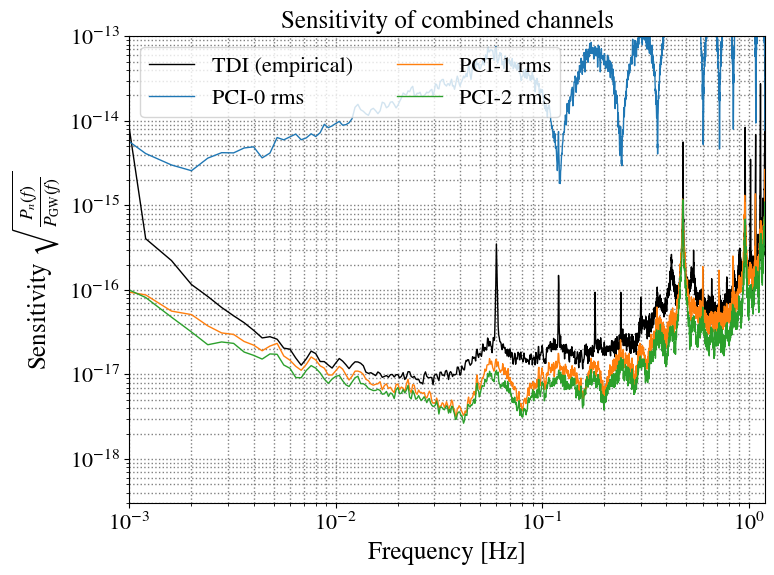

In [33]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

#### Reconstructed single-link sensitivities

In [34]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]

shape in build datamatrix (172710, 546)
single link data shape (6, 172710)
shape in build datamatrix (172710, 546)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.90876067e-37+0.00000000e+00j  1.54240006e-37+0.00000000e+00j
   -5.22547819e-38+0.00000000e+00j -1.90486036e-37+0.00000000e+00j
   -1.54620509e-37+0.00000000e+00j  5.25977857e-38+0.00000000e+00j]
  [ 1.54240006e-37-0.00000000e+00j  3.82697571e-37+0.00000000e+00j
   -2.16343429e-37+0.00000000e+00j -1.54295053e-37+0.00000000e+00j
   -3.82806577e-37+0.00000000e+00j  2.15814035e-37+0.00000000e+00j]
  [-5.22547819e-38-0.00000000e+00j -2.16343429e-37-0.00000000e+00j
    1.41409585e-37+0.00000000e+00j  5.24636454e-38+0.00000000e+00j
    2.16300338e-37+0.00000000e+00j -1.40822293e-37+0.00000000e+00j]
  [-1.90486036e-37-0.00000000e+00j -1.54295053e-37-0.00000000e+00j
    5.24636454e-38-0.00000000e+00j  1.90097897e-37+0.00000000e+00j
    1.54674360e-37+0.00000000e+00j -5.

shape in build datamatrix (172710, 1092)
single link data shape (6, 172710)
shape in build datamatrix (172710, 1092)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 6.81079544e-44+0.00000000e+00j  6.22521952e-46+0.00000000e+00j
    2.04797147e-44+0.00000000e+00j -6.81079233e-44+0.00000000e+00j
   -6.23062624e-46+0.00000000e+00j -2.04799320e-44+0.00000000e+00j]
  [ 6.22521952e-46-0.00000000e+00j  2.12617295e-47+0.00000000e+00j
    3.00928240e-46+0.00000000e+00j -6.22519627e-46+0.00000000e+00j
   -2.12659874e-47+0.00000000e+00j -3.00929111e-46+0.00000000e+00j]
  [ 2.04797147e-44-0.00000000e+00j  3.00928240e-46-0.00000000e+00j
    7.07052682e-45+0.00000000e+00j -2.04796900e-44+0.00000000e+00j
   -3.01086292e-46+0.00000000e+00j -7.07058379e-45+0.00000000e+00j]
  [-6.81079233e-44-0.00000000e+00j -6.22519627e-46-0.00000000e+00j
   -2.04796900e-44-0.00000000e+00j  6.81078922e-44+0.00000000e+00j
    6.23060298e-46+0.00000000e+00j  

shape in build datamatrix (172710, 1638)
single link data shape (6, 172710)
shape in build datamatrix (172710, 1638)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.77249363e-44+0.00000000e+00j -1.30873549e-45+0.00000000e+00j
   -9.07366644e-45+0.00000000e+00j -1.77247542e-44+0.00000000e+00j
    1.30854698e-45+0.00000000e+00j  9.07400650e-45+0.00000000e+00j]
  [-1.30873549e-45-0.00000000e+00j  1.21725274e-45+0.00000000e+00j
    3.78419897e-45+0.00000000e+00j  1.30850613e-45+0.00000000e+00j
   -1.21722093e-45+0.00000000e+00j -3.78411401e-45+0.00000000e+00j]
  [-9.07366644e-45-0.00000000e+00j  3.78419897e-45-0.00000000e+00j
    1.37480140e-44+0.00000000e+00j  9.07295103e-45+0.00000000e+00j
   -3.78405120e-45+0.00000000e+00j -1.37478656e-44+0.00000000e+00j]
  [-1.77247542e-44-0.00000000e+00j  1.30850613e-45-0.00000000e+00j
    9.07295103e-45-0.00000000e+00j  1.77245721e-44+0.00000000e+00j
   -1.30831762e-45+0.00000000e+00j -

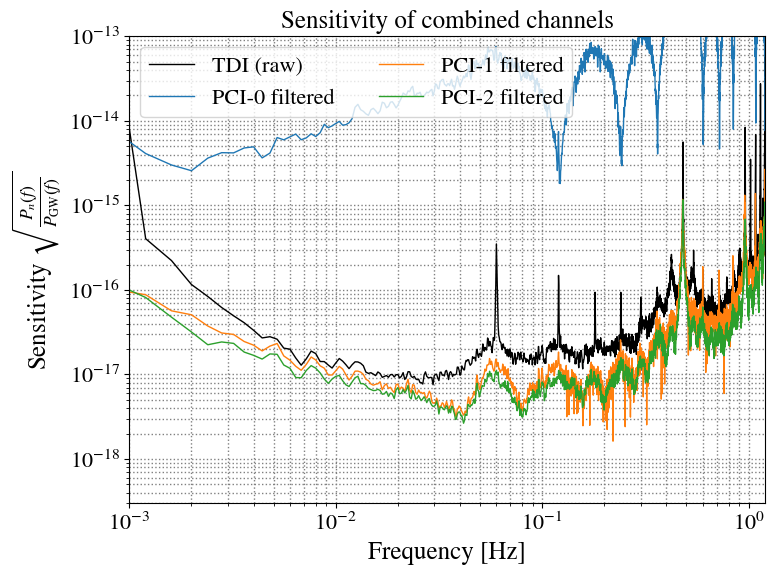

In [35]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()